# Image Augmentation

## Importing Dependencies

In [1]:
# standard python modules
import os # for working with directories
import os.path # for working with paths

#core python modules
from PIL import Image # for loading and saving images
from scipy import ndimage # for core image processing namely, rotate, blur and shift

import numpy as np # for all other maths operations 
import matplotlib.pyplot as plt # for image visualization

#custom project modules
from dataset import get_files 
from dataset import load_dataset, visualize_dataset

### Loading MNIST dataset form binary data file

In [2]:
dataset_size_in_per = 100

train_x_orig, train_y_orig, test_x_orig, test_y_orig = load_dataset(dataset = "mnist", size_in_per = dataset_size_in_per)

print("Sample Size : %d%%\n"%(dataset_size_in_per))
print("Data\t\t\t","Datatype\t\t","Dataset Size")
print("=================================================================")
print("Training Set Images:\t" + str(type(train_x_orig))+"\t",str(train_x_orig.shape))
print("Training Set Labels:\t" + str(type(train_y_orig))+"\t",str(train_y_orig.shape))
print("Test Set Images:\t" + str(type(test_x_orig))+"\t",str(test_x_orig.shape))
print("Test Set Labels:\t" + str(type(test_y_orig))+"\t",str(test_y_orig.shape))
print("=================================================================")



Sample Size : 100%

Data			 Datatype		 Dataset Size
Training Set Images:	<class 'numpy.ndarray'>	 (60000, 28, 28)
Training Set Labels:	<class 'numpy.ndarray'>	 (60000, 1)
Test Set Images:	<class 'numpy.ndarray'>	 (10000, 28, 28)
Test Set Labels:	<class 'numpy.ndarray'>	 (10000, 1)


In [ ]:
visualize_dataset(train_x_orig, train_y_orig, dataset = "mnist", dataset_type = "training")

## Geometric Transformations

(5, 28, 28) (5, 1)


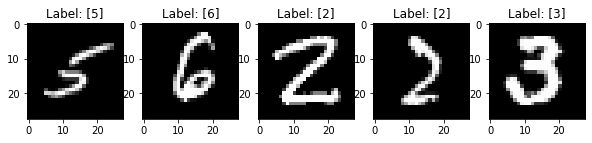

In [5]:
imgs = train_x_orig[15:20]
lbls = train_y_orig[15:20]
print(imgs.shape, lbls.shape)
fig = plt.figure(figsize=(10, 3))
axes= fig.subplots(1, imgs.shape[0])
for i, img in enumerate(imgs):
    axes[i].imshow(img, cmap = "gray")
    axes[i].set_title("Label: %s"%lbls[i])


## Rotating Image

In [6]:
#rotating and rotating+zooming

def rotate(images,labels, save_image = False):
    m = labels.shape[0]
    
    if save_image:
        path = "dataset/mnist_augmented/rotated/"
        if not os.path.exists(path):
            os.makedirs(path)  # creating required directories recursively

    rotated_images = []
    
    for i in range(m):    
        # randomly selecting angle between the range -45 to -15 and 15 to 45
        pos_angle = np.random.randint(low = 10, high = 45)
        neg_angle = np.random.randint(low = -45, high = -10)
        angle = np.random.choice([pos_angle,neg_angle])

        rotated_img = ndimage.rotate(images[i], angle, reshape=False, mode = "nearest")
        
        if(save_image):
            img = Image.fromarray((rotated_img * 255).astype(np.uint8))
            img.save(path + str(labels[i])+"_rotated_"+str(i+1)+".jpg")
            
        rotated_images.append(rotated_img)
    
    return np.asarray(rotated_images), labels

   
    

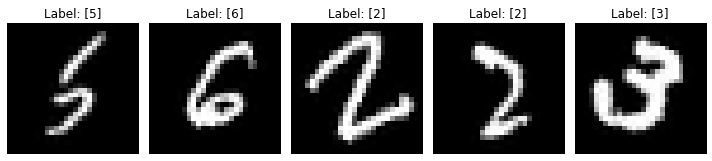

In [7]:
fig = plt.figure(figsize=(10, 3))
axes = fig.subplots(1, imgs.shape[0])

rotated_images, labels = rotate(imgs,lbls, save_image = False)

for i in range(lbls.shape[0]):
    axes[i].imshow(rotated_images[i], cmap='gray')
    axes[i].set_title("Label: %s"%labels[i])
    axes[i].set_axis_off()

fig.set_tight_layout(True)
plt.show()


## Blurring using different filters

In [8]:
#blurring using Gaussian Filter
def blur(images, labels, filter_mode = "random", random_filter = False, save_image = False):
    m = labels.shape[0]
    
    if save_image:
        path = "dataset/mnist_augmented/blurred/"
        if not os.path.exists(path):
            os.makedirs(path)  # creating required directories recursively

    blurred_images = []

    for i in range(m):    
        
        if random_filter:
            filters = ['gaussian', 'maximum', 'minimum', 'median', 'uniform']
            filter_mode = np.random.choice(filters)
            
        if filter_mode == "gaussian":
            sig = np.random.uniform(low = 0, high = 2)
            blurred_img = ndimage.gaussian_filter(images[i], sigma=sig,  mode = "nearest")

        elif filter_mode =="maximum":
            s = np.random.uniform(low = 2, high = 4)
            blurred_img = ndimage.maximum_filter(images[i], size= s,  mode = "nearest")

        elif filter_mode == "minimum":
            s = np.random.uniform(low = 0, high = 4)
            blurred_img = ndimage.minimum_filter(images[i], size= s,  mode = "nearest")

        elif filter_mode == "median":
            s = np.random.randint(low = 2, high = 6)
            blurred_img = ndimage.median_filter(images[i], size= s,  mode = "nearest")

        elif filter_mode == "uniform":
            s = np.random.uniform(low = 2, high = 6)
            blurred_img = ndimage.uniform_filter(images[i], size= s, mode = "nearest")

        else:
            raise ValueError("filter mode should only be 'gaussian', 'maximum', 'minimum', 'median', or 'uniform'")
        
        if(save_image):
                img = Image.fromarray((blurred_img * 255).astype(np.uint8))
                img.save(path + str(labels[i])+"_blurred_"+filter_mode+"_"+str(i+1)+".jpg")

        blurred_images.append(blurred_img)
    
    return np.asarray(blurred_images), labels


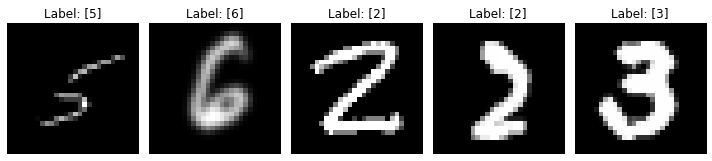

In [9]:
fig = plt.figure(figsize=(10, 3))
axes = fig.subplots(1, imgs.shape[0])

blurred_images, labels = blur(imgs,lbls, filter_mode = "maximum",random_filter = True, save_image = False)

for i in range(lbls.shape[0]):
    axes[i].imshow(blurred_images[i], cmap='gray')
    axes[i].set_title("Label: %s"%labels[i])
    axes[i].set_axis_off()

fig.set_tight_layout(True)
plt.show()


## Shifting Image

In [10]:
#Shifting image
def shift(images,labels, shifting ="both", save_image = False):
    m = labels.shape[0]
    
    if save_image:
        path = "dataset/mnist_augmented/shifted/"
        if not os.path.exists(path):
            os.makedirs(path)  # creating required directories recursively

    shifted_images = []
    
    for i in range(m):    
         # randomly selecting angle between the range -45 to -15 and 15 to 45
        
        if shifting == "horizontal":
            xs = 0
            ys = np.random.uniform(low = -6, high = 6)
            
            
        elif shifting == "vertical":
            ys = 0
            xs = np.random.uniform(low = -6, high = 6)
            
        elif shifting == "both":
            xs = np.random.uniform(low = -6, high = 6)
            ys = np.random.uniform(low = -6, high = 6)
        else:
            raise ValueError("Shifting should only be 'horizontal', 'vertical', or 'both'")
            

        shifted_img = ndimage.shift(images[i], shift= (xs,ys), mode = "nearest")
        
        if(save_image):
            img = Image.fromarray((shifted_img * 255).astype(np.uint8))
            img.save(path + str(labels[i])+"_shifted_"+shifting+"_"+str(i+1)+".jpg")
            
        shifted_images.append(shifted_img)
    
    return np.asarray(shifted_images), labels

   

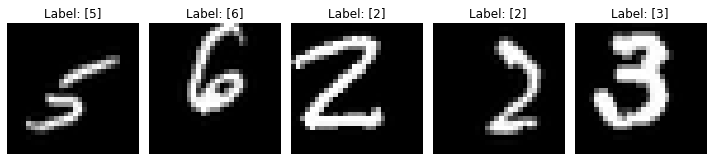

In [11]:
fig = plt.figure(figsize=(10, 3))
axes = fig.subplots(1, imgs.shape[0])

shifted_images, labels = shift(imgs,lbls, shifting ="both", save_image = False)

for i in range(lbls.shape[0]):
    axes[i].imshow(shifted_images[i], cmap='gray')
    axes[i].set_title("Label: %s"%labels[i])
    axes[i].set_axis_off()

fig.set_tight_layout(True)
plt.show()


## Cropping and Padding

In [12]:
#cropping image
def crop_and_pad(images, labels, crop_center = True, save_image = False):
   
    m = labels.shape[0]
    
    if save_image:
        path = "dataset/mnist_augmented/cropped_and_padded/"
        if not os.path.exists(path):
            os.makedirs(path)  # creating required directories recursively

    cropped_images = []
    
    for i in range(m):    
        lx, ly = imgs[i].shape
        cropped_image = np.zeros((lx,ly))
        cropped_image.fill(0) #padding with pixelvalue; 255 for white and 0 for black padding
        if crop_center: # this will work as zoom and crop
            # randomly selecting  the range for central cropping
            c = np.random.randint(low = 4, high = 10)
            cropped_image[lx // c: - lx // c, ly // c: - ly // c] = np.copy(images[i][lx // c: - lx // c, ly // c: - ly // c])
        else: 
            # randomly selecting  the range for cropping across different axis
            clx = np.random.randint(low = 4, high = 10)
            crx= np.random.randint(low = 4, high = 10)
            cly = np.random.randint(low = 4, high = 10)
            cry = np.random.randint(low = 4, high = 10)
            
            cropped_image[lx // clx: - lx // crx, ly // cly: - ly // cry] = np.copy(imgs[i][lx // clx: - lx // crx, ly // cly: - ly // cry])

        if(save_image):
            img = Image.fromarray((cropped_image * 255).astype(np.uint8))
            img.save(path + str(labels[i])+"_cropped_"+str(i+1)+".jpg")
            
        cropped_images.append(cropped_image)
    
    return np.asarray(cropped_images), labels


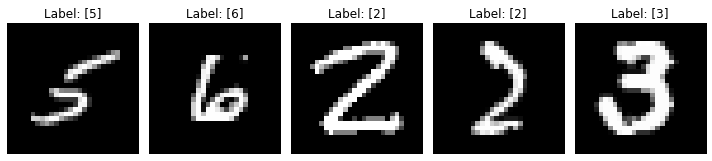

In [14]:
fig = plt.figure(figsize=(10, 3))
axes = fig.subplots(1, imgs.shape[0])

cropped_images, labels = crop_and_pad(imgs,lbls,crop_center = True, save_image = False)

for i in range(lbls.shape[0]):
    axes[i].imshow(cropped_images[i], cmap='gray')
    axes[i].set_title("Label: %s"%labels[i])
    axes[i].set_axis_off()

fig.set_tight_layout(True)
plt.show()


## Flip Image

In [15]:
#Flipping image


def horizontal_flip(images,labels, save_image = False):
    m = labels.shape[0]
    
    if save_image:
        path = "dataset/mnist_augmented/h_flipped/"
        if not os.path.exists(path):
            os.makedirs(path)  # creating required directories recursively

    flipped_images = []
    
    for i in range(m):    
        flip_h = np.fliplr(images[i])

        if(save_image):
#             https://stackoverflow.com/questions/55319949/pil-typeerror-cannot-handle-this-data-type
            img = Image.fromarray((flip_h * 255).astype(np.uint8))
            img.save(path + str(labels[i])+"_hFlipped_"+str(i+1)+".jpg")
            
        flipped_images.append(flip_h)
    
    return np.asarray(flipped_images), labels



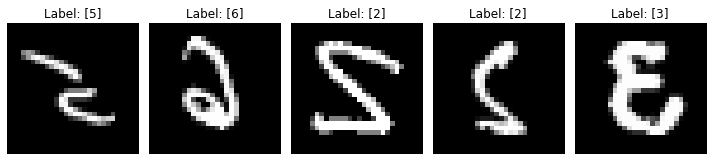

In [16]:
fig = plt.figure(figsize=(10, 3))
axes = fig.subplots(1, imgs.shape[0])

flipped_images, labels = horizontal_flip(imgs,lbls,save_image = True)

for i in range(lbls.shape[0]):
    axes[i].imshow(flipped_images[i], cmap='gray')
    axes[i].set_title("Label: %s"%labels[i])
    axes[i].set_axis_off()

fig.set_tight_layout(True)
plt.show()


In [ ]:
def img_augment(images, labels, rescale = None, horizontal_flip = False, crop_and_pad = False, rotate = False, shift = None, blur = None, save_images = False,):
    pass
     

In [ ]:
fig = plt.figure(figsize=(10, 3))
axes = fig.subplots(1, imgs.shape[0])

flipped_images, labels = img_augment(imgs,lbls,save_image = True)

for i in range(lbls.shape[0]):
    axes[i].imshow(flipped_images[i], cmap='gray')
    axes[i].set_title("Label: %s"%labels[i])
    axes[i].set_axis_off()

fig.set_tight_layout(True)
plt.show()


## Loading images from the directory

In [ ]:

def load_images_from_file(path):
    #checking for the validity of the path
    if not os.path.exists(path):
            raise ValueError("Given folder doesnot exist")

    image_names = sorted(get_files(image_path))
    images = []
    lbls = []
    for image_name in image_names:
        fname = image_path + image_name
        image_data = np.asarray(Image.open(fname).resize((28,28)).convert('L')).reshape(28,28)
        if image_data[1,1] > 250: #if background is white, reversing the fore and background color
            image_data = 255 - image_data
        images.append(image_data.tolist())
        lbls.append(image_name[0])

    real_images = np.asarray(images)
    labels = np.asarray(lbls)
    
    return real_images, labels


image_path = "Sample Images/"
images, labels = load_images_from_file(path = image_path)
# print(images.shape)    


imgs = images[5:10]
lbls = labels[5:10]

print(imgs.shape, lbls.shape)
fig = plt.figure(figsize=(10, 3))
axes= fig.subplots(1, imgs.shape[0])
for i, img in enumerate(imgs):
    axes[i].imshow(img, cmap = "gray")
    axes[i].set_title("Label: %s"%lbls[i])
print(imgs[1][1,1])

In [ ]:
import sys
#real value mapping of  image
fig = plt.figure(figsize=(10, 3))
axes = fig.subplots(1, imgs.shape[0])
m = lbls.shape[0]

for i in range(m):    
    # randomly selecting angle between the range -45 to -15 and 15 to 45
    r = np.divide(imgs[i] , 127.5) - 1

    axes[i].imshow(r, cmap='gray')
    axes[i].set_title("Label: %s"%lbls[i])
    axes[i].set_axis_off()
    
fig.set_tight_layout(True)
plt.show()
print(sys.getsizeof(r), sys.getsizeof(p))


In [ ]:
from time import sleep

from itertools import cycle


for frame in cycle(r'-\|/-\|/'):
    print('\r', frame, sep=' ', end='', flush=True)
    sleep(0.2)

In [ ]:
y = np.zeros((1,5,5))
y.fill(255)
print(y)
x = np.array([[0,1,2,3,4],[5,6,7,8,9],[10,11,0,13,14],[15,0,17,0,19],[0,21,22,23,0]]).reshape(1,5,5)
print(x[0])
# print(y[0][1:-1,1:-1])
y[0][1:-1,1:-1]= np.copy(x[0][1:-1,1:-1])
print(y)
plt.imshow(y[0])

# y = np.concatenate((x,x))
# print(y.shape)
# print(y)

In [ ]:
a = np.array([[[1, 2], [3, 4]]])
c = np.array([[[5, 2], [3, 7]]])


for i in range(3):    
    c= np.concatenate((c, a), axis=0)
    print(c.shape)    
print(c)
